<a href="https://colab.research.google.com/github/Gabriele90/Biohacker90/blob/main/Kfold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**K Fold Cross Validation**

In case of K Fold cross validation input data is divided into ‘K’ number of folds, hence the name K Fold. Suppose we have divided data into 5 folds i.e. K=5. Now we have 5 sets of data to train and test our model. So the model will get trained and tested 5 times, but for every iteration we will use one fold as test data and rest all as training data. Note that for every iteration, data in training and test fold changes which adds to the effectiveness of this method.

This significantly reduces underfitting as we are using most of the data for training(fitting), and also significantly reduces overfitting as most of the data is also being used in validation set. K Fold cross validation helps to generalize the machine learning model, which results in better predictions on unknown data.

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model, tree, ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt

**Load Dataset**

In [2]:
train_data = pd.read_csv('train_molecule_new_features.csv')
# Remove rows with missing target values
train_data.dropna(axis=0, subset=['Polar Surface Area'], inplace=True)
y = train_data # Target variable             
train_data.drop(['Polar Surface Area'], axis=1, inplace=True) # Removing target variable from training data

train_data.drop(['PEOE_VSA1','Fingerprint','smiles','target'], axis=1, inplace=True) # Remove columns with null values

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()

print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

X.head()

Shape of input data: (7464, 10) and shape of target variable: (7464, 10)


,index,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,fr_phos,aromatic_carbocycles,MolLogP
0,2808,3.0,1.0,98.105,1.0,1.0,0.0,0,0,0.56522
1,5043,3.0,1.0,115.176,1.0,0.0,2.0,0,0,1.88260
2,7354,3.0,1.0,268.229,4.0,3.0,2.0,0,0,-1.85660
3,4078,3.0,0.0,408.093,0.0,0.0,4.0,0,0,-9.37680
4,1631,3.0,1.0,147.004,0.0,1.0,0.0,0,1,2.99340


Understanding the Data

Final dataset contains 10 features and 7464 training examples. We have to predict the polar surface area based on available training data.

**Model Score Using KFold**


Let’s use cross_val_score() to evaluate a score by cross-validation. We are going to use three different models for analysis. We will find the score for every split and then take average to get the overall score. We will analyze the model performance based on Root Mean Square Error (RMSE). Since RMSE is not directly available from scoring parameter, first we find the Mean Square Error and then take the square root of it.

**Splitting the data into 5 folds.  **

We will use this 'kf'(KFold splitting stratergy) object as input to cross_val_score() method

In [3]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 5971, Test set:1493
Fold:2, Train set: 5971, Test set:1493
Fold:3, Train set: 5971, Test set:1493
Fold:4, Train set: 5971, Test set:1493
Fold:5, Train set: 5972, Test set:1492


Classification accuracy is reward function, means something you want to maximize. Mean Square Error is loss function, 
means something you want to minimize. Now if we use 'cross_val_score' function then best score(high value) will give worst 
model in case of loss function! There are other sklearn functions which also depends on 'cross_val_score' to select best model by
looking for highest scores, so a design decision was made for 'cross_val_score' to negate the output of all loss function. 
So that when other sklearn function calls 'cross_val_score' those function can always assume that highest score indicate better model.
In short ignore the negative sign and rate the error based on its absolute value.

In [4]:
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

**Using Linear Regression**

In [5]:
score = cross_val_score(linear_model.LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-9.12657478e-27 -4.69959074e-25 -2.96281944e-25 -8.41378957e-25
 -6.74689503e-27]
rmse= 0.00


**Using Decision Tree Regressor**

In [6]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-364.056701   -244.54291632 -232.69835213 -322.95691891 -258.07395011]
rmse= 16.87


**Using Random Forest Regressor**

In [7]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())


Scores for each fold are: [-166.13090766 -107.83069044  -93.88709801 -139.29445462  -79.29073968]
rmse= 10.83


**Model Tuning using KFold**

We can also use cross_val_score() along with KFold to evaluate the model for different hyperparameters. Here we are going to try different hyperparameter values and choose the ones for which we get the highest model score.

**Decision Tree Regressor Tuning**

There are multiple hyperparameters like max_depth, min_samples_split, min_samples_leaf etc which affect the model performance. Here we are going to do tuning based on ‘max_depth’. We will try with max depth starting from 1 to 10 and depending on the final ‘rmse’ score choose the value of max_depth.

In [8]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    rmse(score.mean())

For max depth: 1
rmse= 345.20
For max depth: 2
rmse= 178.73
For max depth: 3
rmse= 100.85
For max depth: 4
rmse= 68.62
For max depth: 5
rmse= 56.51
For max depth: 6
rmse= 40.63
For max depth: 7
rmse= 30.51
For max depth: 8
rmse= 23.64
For max depth: 9
rmse= 20.12
For max depth: 10
rmse= 17.63


**Random Forest Regressor Tuning**

There are multiple hyperparameters like n_estimators, max_depth, min_samples_split etc which affect the model performance. Here we are going to do tuning based on ‘n_estimators’. We will try with estimators starting from 50 to 350 and depending on the final ‘rmse’ score choose the value of estimator.

In [9]:
estimators = [50, 100, 150, 200, 250, 300, 350]

for count in estimators:
    score = cross_val_score(ensemble.RandomForestRegressor(n_estimators= count, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    rmse(score.mean())

For estimators: 50
rmse= 10.88
For estimators: 100
rmse= 10.83
For estimators: 150
rmse= 10.74
For estimators: 200
rmse= 10.73
For estimators: 250
rmse= 10.73
For estimators: 300
rmse= 10.72
For estimators: 350
rmse= 10.70


**Building multiple linear regression model using k-fold CV to evaluate model**

In [11]:
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error',
                         cv=kf, n_jobs=-1)

**Viewing mean absolute error**

In [12]:
mean(absolute(scores))

1.5025951730111228e-13

From the output we can see that the mean absolute error (MAE) is very low. 
In general, the lower the MAE, the more closely a model is able to predict the actual observations.

Another commonly used metric to evaluate model performance is the root mean squared error (RMSE). The following code shows how to calculate this metric using LOOCV:

In [13]:
sqrt(mean(absolute(scores)))

3.876332252285816e-07

**Using the entire dataset for model training**

In [17]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
predictions = model.predict(X)

**Plotting the results**

In [21]:
import matplotlib.pyplot as plt

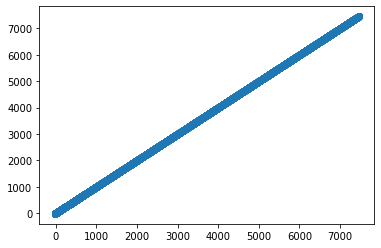

In [22]:
plt.scatter(y, predictions)

(array([[ 0.,  0.,  0., ...,  9.,  1.,  0.],
        [ 0.,  0.,  0., ...,  9.,  1.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  1.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]]),
 array([-2.10320650e-12, -1.82467375e-12, -1.54614099e-12, -1.26760824e-12,
        -9.89075488e-13, -7.10542736e-13, -4.32009983e-13, -1.53477231e-13,
         1.25055521e-13,  4.03588274e-13,  6.82121026e-13]),
 <a list of 7464 Lists of Patches objects>)

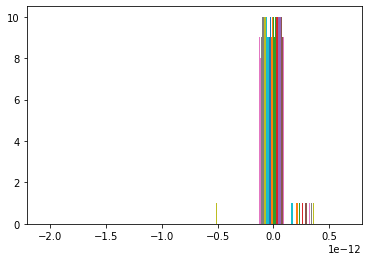

In [23]:
plt.hist(y - predictions)